In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [ ]:
raw_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Nickel_Final_DB1.csv')

In [ ]:
raw_df

,Date,Price,Y2_Price,Y10_Price,UC_Price,EU_Price,GB_Price,JP_Price,NetWeight,TradeValue,WTI_Price,B_Price,Gas_Price,heating_Price,NAV,Dollor_Price,Stock,STS_price,Current_Price,CRB_Price
0,2011.1.4,25120.0,0.6210,3.338,6.6070,0.7514,0.6415,82.06,779926682,155396452.0,89.38,93.53,4.669,2.5065,31.64,79.440,136890.0,100.700,25175.0,327.76
1,2011.1.5,24720.0,0.7080,3.463,6.6193,0.7603,0.6448,83.19,779926682,155396452.0,90.30,95.50,4.473,2.5422,31.91,80.260,136860.0,100.700,24650.0,329.23
2,2011.1.6,24534.0,0.6770,3.399,6.6263,0.7686,0.6464,83.31,779926682,155396452.0,88.38,94.52,4.434,2.5112,31.57,80.790,137040.0,100.700,24875.0,325.10
3,2011.1.7,24180.0,0.5970,3.328,6.6282,0.7746,0.6428,83.14,779926682,155396452.0,88.03,93.33,4.422,2.4863,31.65,81.010,136896.0,100.700,24345.0,323.98
4,2011.1.10,23847.0,0.5730,3.287,6.6369,0.7723,0.6421,82.72,779926682,155396452.0,89.25,95.70,4.399,2.5561,31.88,80.880,136806.0,100.700,24050.0,326.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,2022.5.23,27732.0,2.6287,2.861,6.6490,0.9352,1.2588,127.87,49104116,16801717.0,109.77,110.78,8.796,3.7818,22.44,102.097,71922.0,177.145,26800.0,335.74
2779,2022.5.24,26550.0,2.4807,2.754,6.6530,0.9314,1.2529,126.80,49104116,16801717.0,110.33,110.69,8.971,3.8664,22.17,101.870,72120.0,177.145,26280.0,334.21
2780,2022.5.25,26788.0,2.5020,2.751,6.6916,0.9360,1.2564,127.31,49104116,16801717.0,114.09,111.12,8.908,3.9680,22.06,102.077,72600.0,177.145,26725.0,335.09
2781,2022.5.26,27198.0,2.4778,2.742,6.7380,0.9321,1.2594,127.14,49104116,16801717.0,115.07,114.17,8.727,4.0029,22.28,101.858,72300.0,177.145,27550.0,339.46


'Y2_Price','UC_Price',
       'GB_Price', 'WTI_Price',
       'heating_Price', 'NAV', 'Dollor_Price', 'CRB_Price'

In [ ]:
df = raw_df[['Date', 'Y2_Price','UC_Price', 'GB_Price', 'WTI_Price', 
             'heating_Price', 'NAV', 'Dollor_Price', 'CRB_Price', 'Price']]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2783 entries, 2011-01-04 to 2022-05-27
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Y2_Price       2783 non-null   float64
 1   UC_Price       2783 non-null   float64
 2   GB_Price       2783 non-null   float64
 3   WTI_Price      2783 non-null   float64
 4   heating_Price  2783 non-null   float64
 5   NAV            2783 non-null   float64
 6   Dollor_Price   2783 non-null   float64
 7   CRB_Price      2783 non-null   float64
 8   Price          2783 non-null   float64
dtypes: float64(9)
memory usage: 217.4 KB


In [ ]:
x_cols = list(df.columns)
x_cols.remove("Price")

test_data_size = 700
X = df[x_cols]
Y = df['Price']


scaler = MinMaxScaler()

Xscaler = scaler.fit(X)
Yscaler = scaler.fit(Y.values.reshape(-1,1))

Y = Y.values.reshape(-1, 1)

X_train = scaler.fit_transform(X[:-test_data_size])
X_test = scaler.transform(X[-test_data_size:])
y_train = scaler.fit_transform(Y[:-test_data_size]).flatten()
y_test = scaler.transform(Y[-test_data_size:]).flatten()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2083, 8)
(700, 8)
(2083,)
(700,)


In [ ]:
def create_sequences(array, seq_length) :
  res = []
  if seq_length == 1:
    for i in range(len(array)) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  else :
    for i in range(len(array) - seq_length-1) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  return res

In [ ]:
seq_length = 1

X_train = create_sequences(X_train, seq_length)
X_test = create_sequences(X_test, seq_length)
y_train = create_sequences(y_train, seq_length)
y_test = create_sequences(y_test, seq_length)

In [ ]:
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([2083, 1, 8]) torch.Size([700, 1, 8])
torch.Size([2083, 1]) torch.Size([700, 1])


In [ ]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 텐서 형태로 데이터 정의
dataset = TensorDataset(X_train, y_train)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        shuffle=True,  
                        drop_last=True)

# Building a Model

LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

CNN-LSTM

# Training

In [ ]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, lr=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() 
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_hist = []
    train_result = []
    val_hist = []
    val_result = []

    for t in range(num_epochs):

        epoch_loss = 0
        for idx, seq in enumerate(train_data): 
            model.reset_hidden_state() # seq 별 hidden state reset
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss
            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            epoch_loss += loss.item()

            np.append(train_hist, (epoch_loss / len(train_data)))
            
        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):
                    model.reset_hidden_state() # seq 별로 hidden state 초기화 
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])
                    val_loss += val_step_loss

                    np.append(val_hist, (val_loss / len(val_data)).cpu()) # val hist에 추가


            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :
                    print('\n Early Stopping')
                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model.eval(), train_result, val_result #train_hist, val_hist

# LSTM

In [ ]:
n_features=X_train.shape[-1]
n_hidden=1 # 1이 베스트
n_layers=3 # 3이 베스트
lr=1e-3
num_epochs=100

In [ ]:
model = LSTM(
    n_features=n_features,
    n_hidden=n_hidden, # 1이 베스트
    seq_len=seq_length,
    n_layers=n_layers # 3이 베스트
).to(device)

model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    lr=lr,
    num_epochs=num_epochs,
    verbose=20,
    patience=200
)

Epoch 0 train loss: 0.1771942754466117 val loss: 0.2597174048423767
Epoch 20 train loss: 0.03720948551488621 val loss: 0.23739776015281677
Epoch 40 train loss: 0.03545141368532089 val loss: 0.24103103578090668
Epoch 60 train loss: 0.03319317921888811 val loss: 0.23910941183567047
Epoch 80 train loss: 0.031141848326180055 val loss: 0.23431219160556793


In [ ]:
# plotting Loss
plt.plot(train_result, label="Training loss")
plt.plot(val_result, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

NameError: ignored

In [ ]:
with torch.no_grad():
  preds = []
  for i in range(len(X_test)):
    test_seq = X_test[i:i+1]
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(X_train.shape[-1], seq_length, 1).float()

In [ ]:
preds


[0.38644635677337646,
 0.4013604521751404,
 0.3984510600566864,
 0.3898041844367981,
 0.38220953941345215,
 0.37581419944763184,
 0.3699605464935303,
 0.3645364046096802,
 0.3588278591632843,
 0.3546454906463623,
 0.3560856580734253,
 0.35968017578125,
 0.36332690715789795,
 0.36728402972221375,
 0.36937475204467773,
 0.3671121597290039,
 0.3639821708202362,
 0.3610721528530121,
 0.3589925169944763,
 0.35043662786483765,
 0.34450873732566833,
 0.335660845041275,
 0.3324495255947113,
 0.33165988326072693,
 0.3312014937400818,
 0.33394432067871094,
 0.3340478241443634,
 0.32826608419418335,
 0.32666435837745667,
 0.3226723372936249,
 0.3166104555130005,
 0.3106398284435272,
 0.30581003427505493,
 0.29225417971611023,
 0.2883729040622711,
 0.2830938398838043,
 0.27796339988708496,
 0.2737261652946472,
 0.27279332280158997,
 0.27335819602012634,
 0.2728691101074219,
 0.27357882261276245,
 0.276192843914032,
 0.2808365821838379,
 0.28170427680015564,
 0.2831019163131714,
 0.2854588031768799

In [ ]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
pred_values

array([[15913.28163218],
       [16234.50141895],
       [16171.8389315 ],
       [15985.6025244 ],
       [15822.02905989],
       [15684.2862277 ],
       [15558.21025038],
       [15441.38508248],
       [15318.43443066],
       [15228.35457754],
       [15259.37290359],
       [15336.79162598],
       [15415.33492637],
       [15500.56343216],
       [15545.59340954],
       [15496.86169624],
       [15429.44799513],
       [15366.77202815],
       [15321.98083103],
       [15137.70409095],
       [15010.02918452],
       [14819.4632805 ],
       [14750.29788226],
       [14733.29056567],
       [14723.41777217],
       [14782.49277878],
       [14784.72203642],
       [14660.19492137],
       [14625.69695073],
       [14539.71680063],
       [14409.15599084],
       [14280.56062502],
       [14176.53651822],
       [13884.57052273],
       [13800.97560769],
       [13687.27512342],
       [13576.77570677],
       [13485.51414812],
       [13465.4225865 ],
       [13477.58882588],


In [ ]:
pred_values_ceiled  = list(pred_values.flatten())

# True value 스케일링 역변환
true_values = Yscaler.inverse_transform(np.array(y_test.cpu()).reshape(-1,1))
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

score_table

,True,Pred
0,14137.999023,15913.281632
1,14345.000000,16234.501419
2,14307.999023,16171.838932
3,14553.000000,15985.602524
4,14473.000000,15822.029060
...,...,...
695,27731.998047,19536.938968
696,26550.000000,19536.001820
697,26788.000000,19535.148116
698,27197.998047,19534.484410


In [ ]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 31630434.01194471, RMSE : 5624.094061441781, SCORE : 91.04135647671636


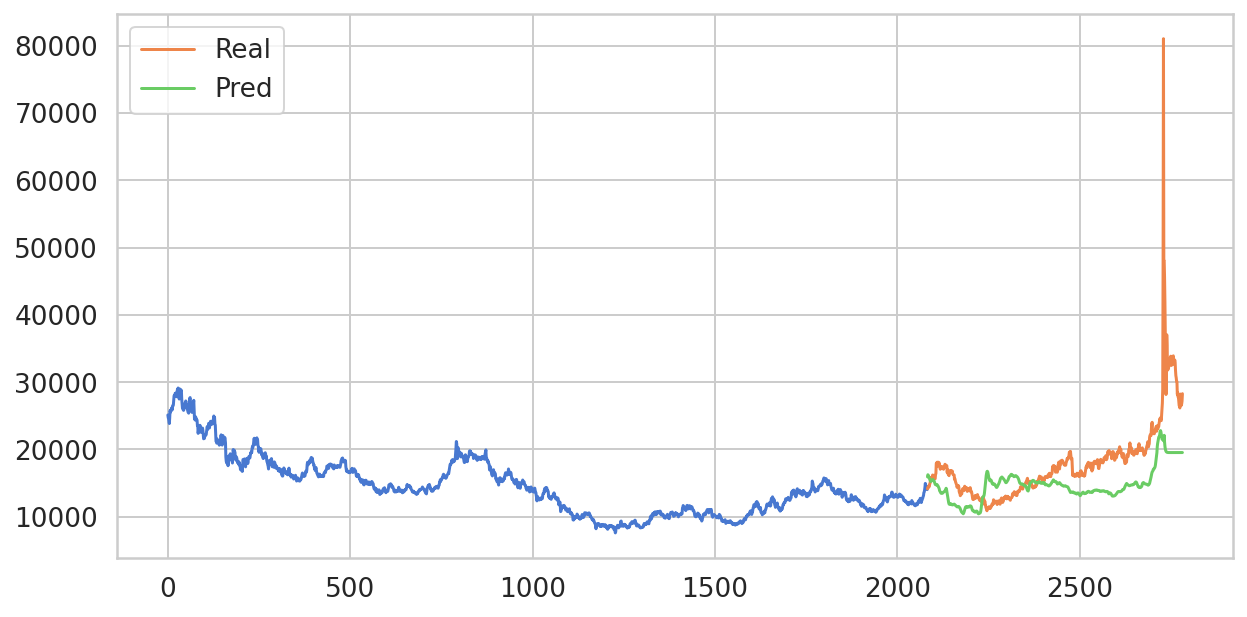

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),Yscaler.inverse_transform(np.array(y_train.cpu()).reshape(-1,1)))
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

# 파라미터 저장

In [ ]:
# 모델 저장
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Elastic/weights/{0}_nickel.pth'.format(score)
torch.save(model, PATH)

In [ ]:
new_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/unsaved (2).csv')

In [ ]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Price'] = pd.to_numeric(new_df['Price']).astype(float)

new_df.set_index('Date', inplace = True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2022-08-05 19:00:00 to 2022-08-06 15:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Y2_Price       21 non-null     float64
 1   UC_Price       21 non-null     float64
 2   GB_Price       21 non-null     float64
 3   WTI_Price      21 non-null     float64
 4   heating_Price  21 non-null     float64
 5   NAV            21 non-null     float64
 6   Dollor_Price   21 non-null     float64
 7   CRB_Price      21 non-null     float64
 8   Price          21 non-null     float64
dtypes: float64(9)
memory usage: 1.6 KB


In [ ]:
x_cols = list(new_df.columns)
x_cols.remove("Price")

new_X = new_df[x_cols]
#Y = new_df['Price']

scaler = MinMaxScaler()
new_Xscaler = scaler.fit(new_X)
new_X_test = scaler.transform(new_X[:])

seq_length = 1

new_X_test = create_sequences(new_X_test, seq_length)
new_X_test = torch.tensor(new_X_test, device=device).float()

print(new_X_test.shape)


torch.Size([21, 1, 8])


In [ ]:
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Elastic/weights/{0}_nickel.pth'.format(score)
# 모델 불러오기
model = torch.load(PATH)

# 불러오기
model = LSTM(
    n_features=X_train.shape[-1],
    n_hidden=1, 
    seq_len=seq_length,
    n_layers=3 #3가 베스트
).to(device) 
model = torch.load(PATH)
model.eval()

LSTM(
  (lstm): LSTM(8, 1, num_layers=3)
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
DAYS_TO_PREDICT = 5

with torch.no_grad():
  new_preds = []
  for i in range(DAYS_TO_PREDICT) :
    new_test_seq = new_X_test[:1]
    new_y_test_pred = model(new_test_seq)
    new_pred = torch.flatten(new_y_test_pred).item()
    new_preds.append(new_pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]
    new_test_seq = torch.as_tensor(new_seq).view(X_train.shape[-1], seq_length, 1).float()

In [ ]:
new_preds

[0.6277708411216736,
 0.7053002715110779,
 0.764379620552063,
 0.8038759231567383,
 0.828728973865509]

In [ ]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(new_preds).reshape(-1,1))

In [ ]:
pred_values

array([[21110.92837608],
       [22780.75724781],
       [24053.20826745],
       [24903.87963295],
       [25439.16463912]])

In [ ]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[21110.928376078606,
 22780.75724780559,
 24053.20826745033,
 24903.879632949825,
 25439.16463911533]

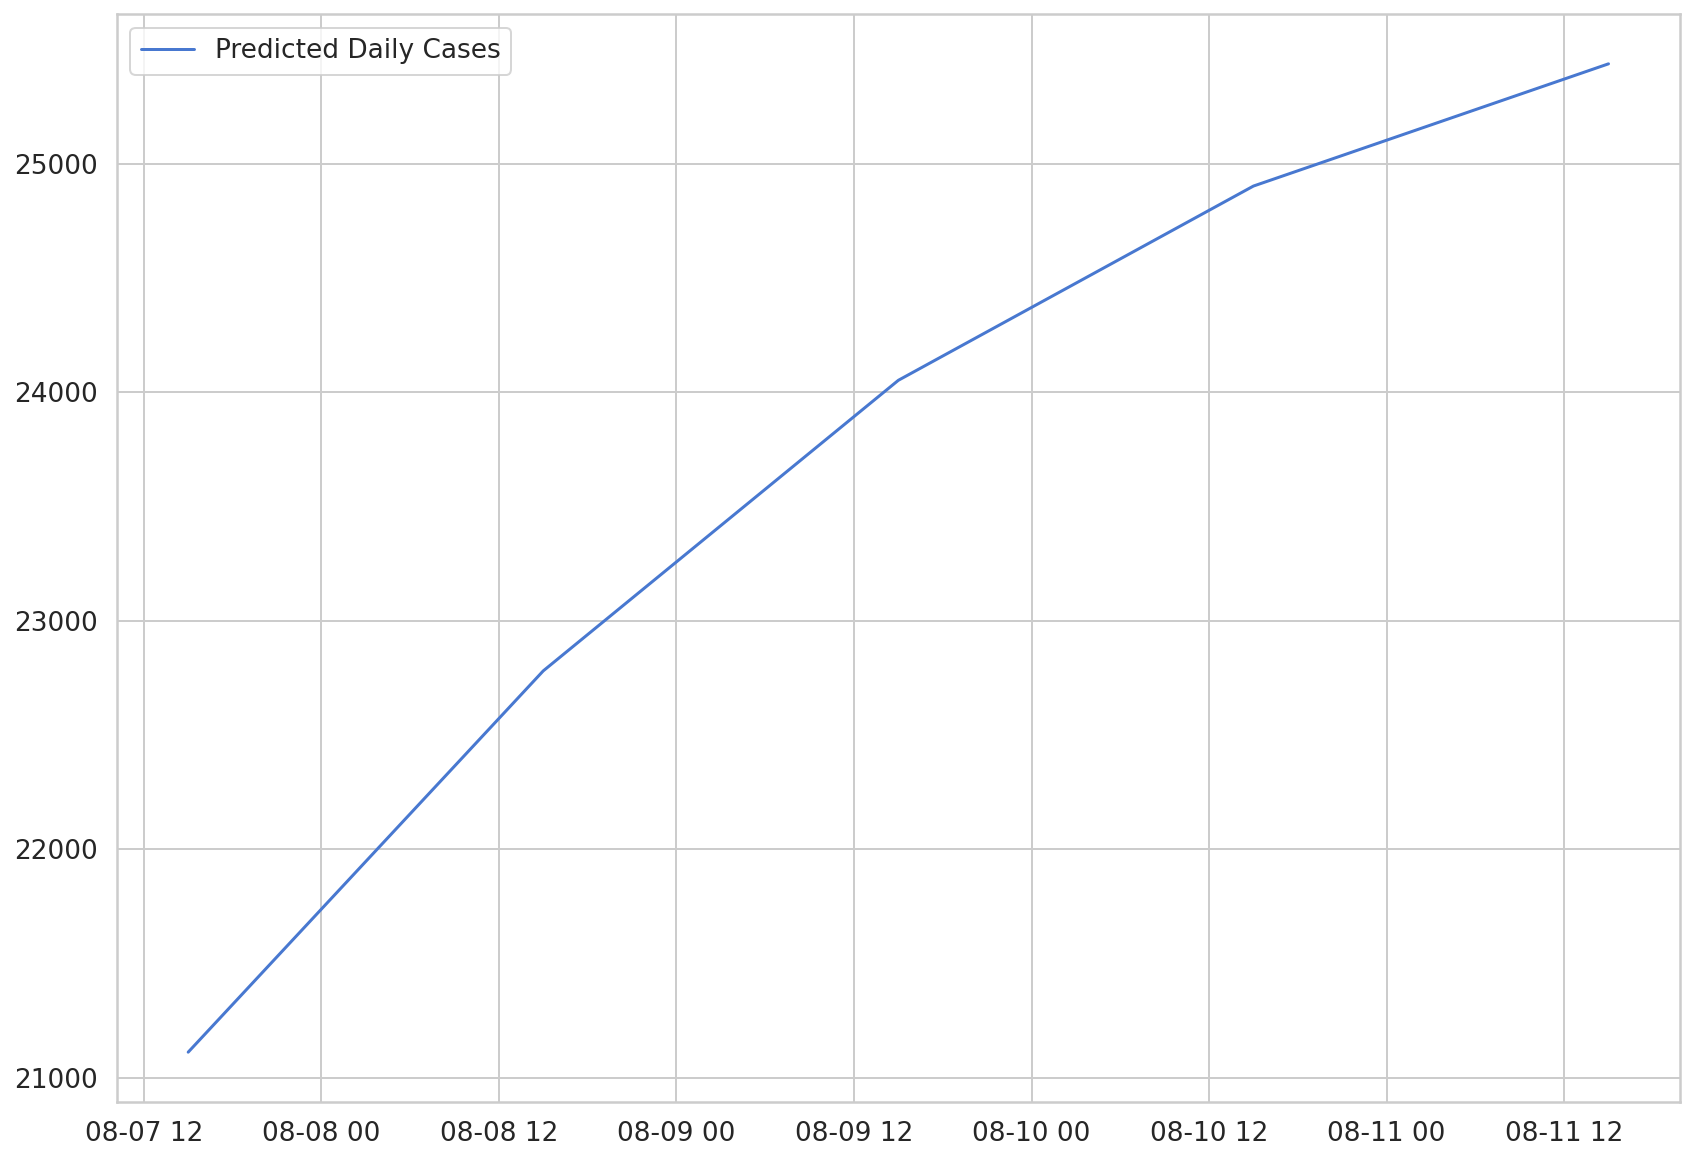

In [ ]:
predicted_index = pd.date_range(
  start=new_df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

# Using all data for Training

In [ ]:
df

,Y2_Price,GB_Price,WTI_Price,heating_Price,NAV,Dollor_Price,CRB_Price,Price
Date,,,,,,,,
2011-01-04,0.6210,0.6415,89.38,2.5065,31.64,79.440,327.76,25120.0
2011-01-05,0.7080,0.6448,90.30,2.5422,31.91,80.260,329.23,24720.0
2011-01-06,0.6770,0.6464,88.38,2.5112,31.57,80.790,325.10,24534.0
2011-01-07,0.5970,0.6428,88.03,2.4863,31.65,81.010,323.98,24180.0
2011-01-10,0.5730,0.6421,89.25,2.5561,31.88,80.880,326.89,23847.0
...,...,...,...,...,...,...,...,...
2022-05-23,2.6287,1.2588,109.77,3.7818,22.44,102.097,335.74,27732.0
2022-05-24,2.4807,1.2529,110.33,3.8664,22.17,101.870,334.21,26550.0
2022-05-25,2.5020,1.2564,114.09,3.9680,22.06,102.077,335.09,26788.0


In [ ]:
# X변수들과 y변수 구분
X_all = df[x_cols]
y_all = df['Price']

In [ ]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = scaler.fit_transform(X_all)
y_all = scaler.fit_transform(y_all.values.reshape(-1,1)).flatten()


In [ ]:
y_all

array([0.23862677, 0.23318178, 0.23064986, ..., 0.26133239, 0.26691351,
       0.28169666])

In [ ]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (2783, 7)
y_all :  (2783,)


In [ ]:
X_all = create_sequences(X_all, seq_length)
y_all = create_sequences(y_all, seq_length)

In [ ]:
X_all = torch.tensor(X_all, device=device).float()
y_all = torch.tensor(y_all, device=device).float()
#X_all = torch.from_numpy(np.array(X_all)).float()
#y_all = torch.from_numpy(np.array(y_all)).float()

In [ ]:
model.eval()
with torch.no_grad() :
  new_preds=[]
  for i in range(len(new_X_test)):
    test_seq = new_X_test[i:i+1]
    new_y_test_pred = model(test_seq)
    new_pred = torch.flatten(new_y_test_pred).item()
    new_preds.append(new_pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]

In [ ]:
DAYS_TO_PREDICT = len(new_X_test)
with torch.no_grad():
    #test_seq = X_all[:1]
    preds = []
    for _ in range(len(new_X_test)):
        y_test_pred = model(new_X_test[i:i+1])
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
DAYS_TO_PREDICT = 7
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[26357.614936828613,
 27509.909418821335,
 27964.848718762398,
 28171.135607004166,
 28271.6556776762,
 28322.45553612709,
 28348.596839547157]

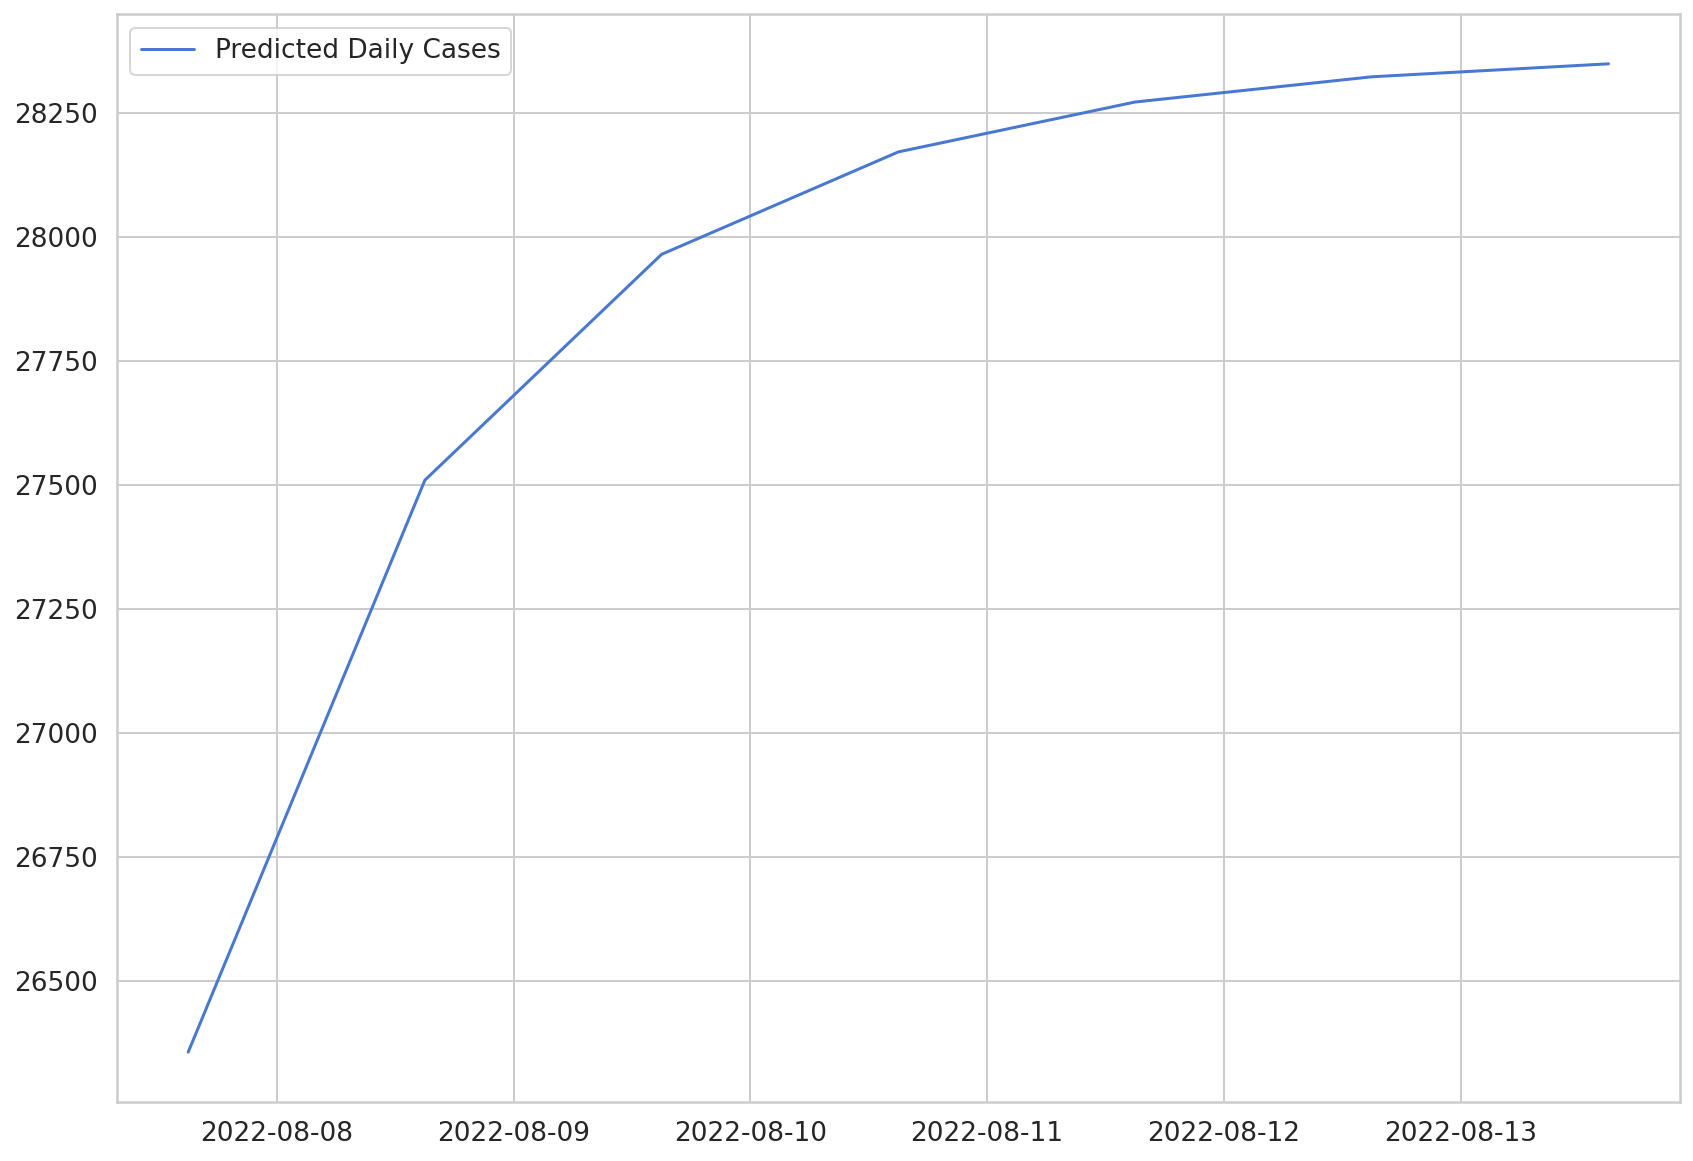

In [ ]:
predicted_index = pd.date_range(
  start=new_df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

preds_

,0
2022-08-07 15:00:00,26357.614937
2022-08-08 15:00:00,27509.909419
2022-08-09 15:00:00,27964.848719
2022-08-10 15:00:00,28171.135607
2022-08-11 15:00:00,28271.655678
2022-08-12 15:00:00,28322.455536
2022-08-13 15:00:00,28348.596840


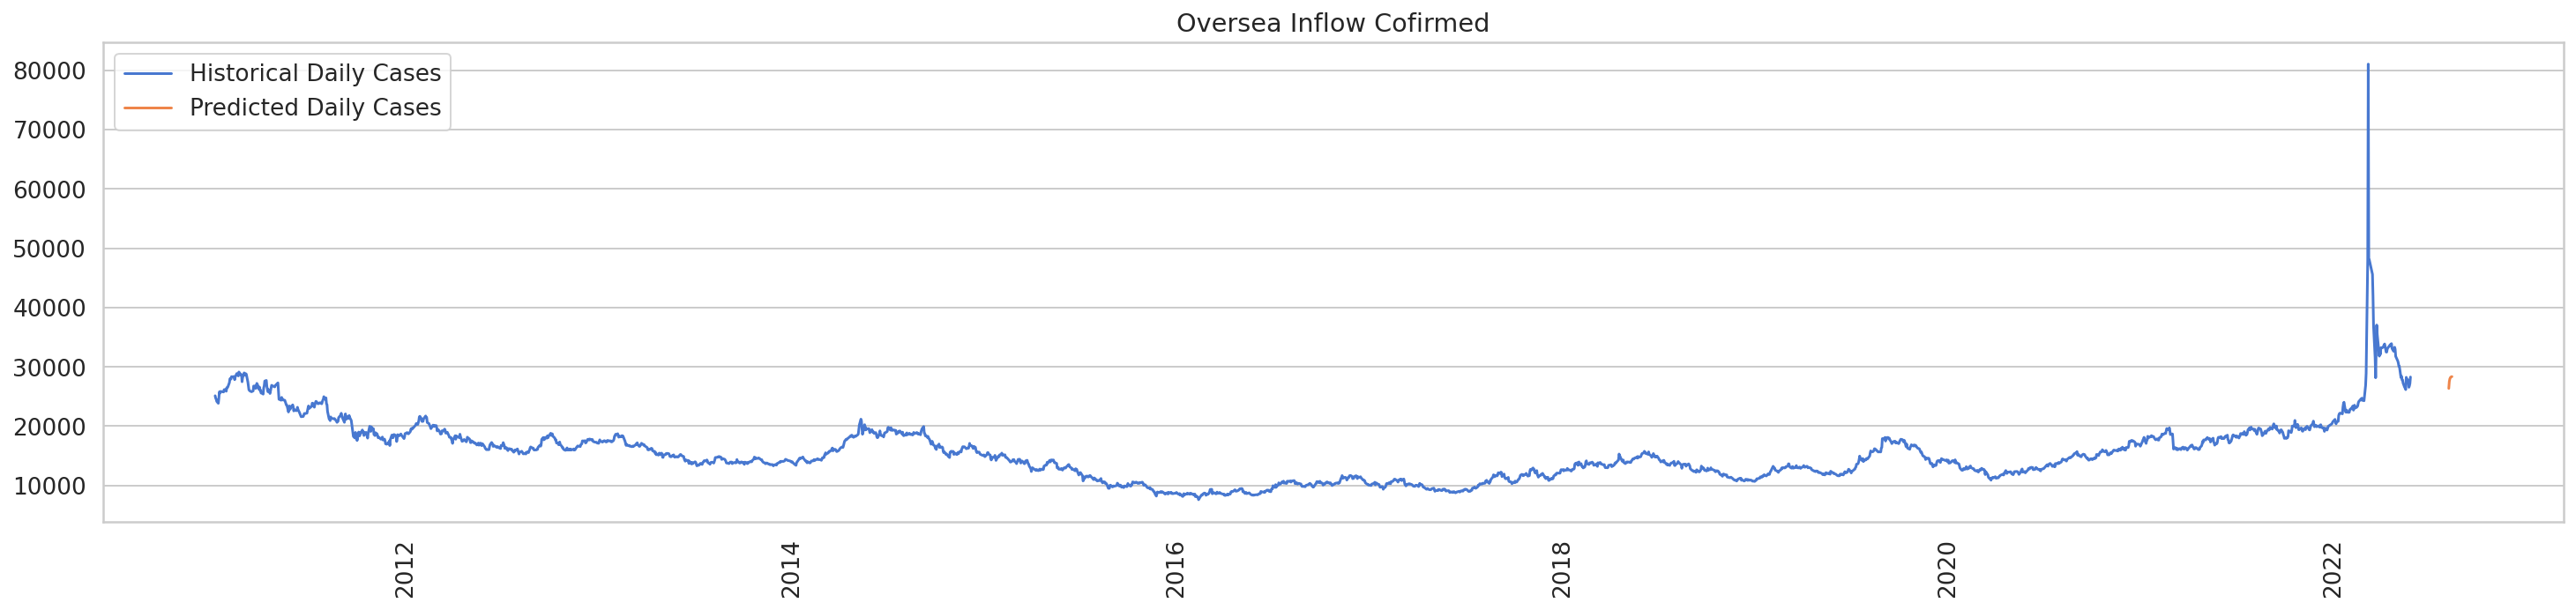

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(df['Price'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();

# CNN-LSTM

In [ ]:
class CNN_LSTM(nn.Module) :
  def __init__(self, n_features, n_hidden, seq_len, n_layers) :
    super(CNN_LSTM, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.c1 = nn.Conv1d(in_channels=n_features, 
                        out_channels=100, 
                        kernel_size = 3, 
                        stride = 2
                        ) # 1D CNN 레이어 추가
    self.lstm = nn.LSTM(
        input_size = 100,
        hidden_size=n_hidden,
        num_layers=n_layers
        )
    
    self.linear = nn.Linear(in_features = n_hidden, out_features = 1)


  def reset_hidden_state(self) :
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden, device=device),
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden, device=device)
    )

  def forward(self, sequences) :
    sequences = self.c1(sequences.view(len(sequences), 1, -1))
    lstm_out, self.hidden = self.lstm(
        sequences.view(sequences.size(0), self.seq_len-1, -1),
        self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
model = CNN_LSTM(
    n_features=X_train.shape[-1],
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
).to(device)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=100,
    verbose=10,
    patience=50
)

RuntimeError: ignored